In [1]:
import cProfile
import os
import pstats
import sys
from pstats import SortKey

import numpy as np
import pandas as pd
from river.decomposition import OnlineDMDwC
from river.preprocessing import Hankelizer
from river.utils import Rolling

Rolling.learn_one = Rolling.update  # type: ignore
sys.path.append("../")

from functions.chdsubid import SubIDChangeDetector, get_default_rank  # noqa: E402
from functions.datasets import load_cats  # noqa: E402
from functions.metrics import chp_score  # noqa: E402
from functions.plot import plot_chd  # noqa: E402
from functions.preprocessing import hankel  # noqa: E402

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Read data
df = load_cats("data/cats/data_1t_agg_last.csv")
df.index = pd.to_datetime(df.index)
U = df[["aimp", "amud", "adbr", "adfl"]]
X = df[
    [
        "bed1",
        "bed2",
        "bfo1",
        "bfo2",
        "bso1",
        "bso2",
        "bso3",
        "ced1",
        "cfo1",
        "cso1",
    ]
]
Y_true = df.pop("y")
Y_cat = df.pop("category")

In [8]:
# What kind of structural changes are we looking for? Steps every 1000 samples
window_size: int = 250
# Base size
ref_size = window_size
test_size = window_size
# If window_size is not very large, then take half
hn = 2
# Optimal low-rank representation of signal with unknown noise variance
p = get_default_rank(hankel(X[:window_size], hn))
print(f"Optimal rank for states is: {p}")
hu = window_size // 2
q = get_default_rank(hankel(U[:window_size], hu))
print(f"Optimal rank for inputs is: {q}")

Optimal rank for states is: 8
Optimal rank for inputs is: 10


Processed 83000/83334

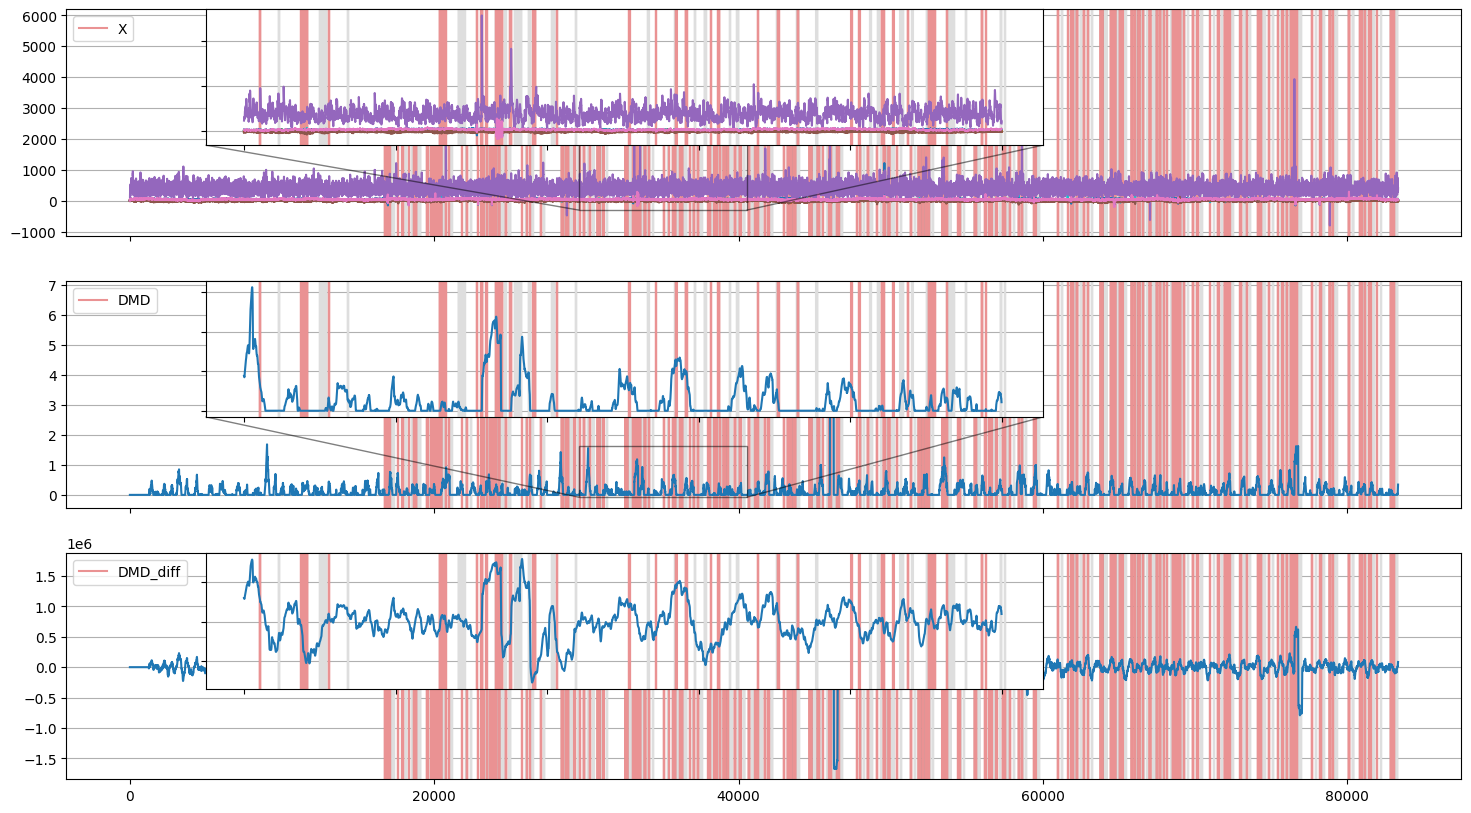

In [9]:
# [donotremove]
# TODO: enable hankelization of us on the fly
U_ = hankel(U, hn=hu)

# Initialize Hankelizer
hankelizer = Hankelizer(hn)

# Initialize Transformer
init_size = window_size * 4
odmd = Rolling(
    OnlineDMDwC(
        p=p,
        q=q,
        initialize=init_size,
        w=1.0,
        exponential_weighting=False,
        eig_rtol=1e-1,
    ),
    init_size + 1,
)

# Initialize Change-Point Detector
ref_size = window_size
test_size = window_size
subid_dmd = SubIDChangeDetector(
    odmd,
    ref_size=ref_size,
    test_size=test_size,
    grace_period=init_size + test_size + 1,
)

# Build pipeline
pipeline_dmd = hankelizer | subid_dmd

# Prepare arrays for storing results
scores_dmd = np.zeros(X.shape[0], dtype=float)
# scores_svd = np.zeros(X.shape[0], dtype=float)
scores_dmd_diff = np.zeros(X.shape[0], dtype=complex)
dist = np.zeros((X.shape[0], 2), dtype=complex)
modes = np.empty((X.shape[0], hn * X.shape[1], p), dtype=complex)

# Run pipeline
for i, ((t, x), (t, u)) in enumerate(
    zip(
        X.iterrows(),
        U_.iterrows(),
    )
):
    # print every 1000
    if (i + 1) % 1000 == 0:
        print(f"\rProcessed {i + 1}/{len(X)}", end="")

    pipeline_dmd.learn_one(x.to_dict(), **{"u": u.to_dict()})

    scores_dmd[i] = subid_dmd.score
    if hasattr(subid_dmd.subid, "modes"):
        modes[i, :, :] = odmd.modes
    if hasattr(subid_dmd, "distances"):
        dist[i, :] = subid_dmd.distances

    scores_dmd_diff[i] = dist[i, 1] - dist[i, 0]

# Plot results
X_ = df.values
Y_ = Y_true.values
fig, axs = plot_chd(
    [X_, scores_dmd.real, scores_dmd_diff.real],
    np.where(Y_ == 1)[0],
    labels=["X", "DMD", "DMD_diff", "SVD"],
    idx_in_start=30000,
    idx_in_end=40000,
    grace_period=test_size,
)
fig_name = (
    f"results/.cats/cats-chd_p{p}_q{q}-"
    f"{f'roll_{odmd.window_size}' if isinstance(odmd, Rolling) else 'noroll'}-"
    f"dmd_w{odmd.w}-hx{hn}-hu{hu}-imag.png"
)
fig.set_size_inches(18, 10)  # Set the size of the figure
os.makedirs(os.path.dirname(fig_name), exist_ok=True)
fig.savefig(fig_name)

In [10]:
pred_shift = 1
y_true = pd.Series(Y_)
y_true.index = pd.to_datetime(y_true.index, unit="s")

y_pred = pd.Series(scores_dmd > 0.01)
y_pred.index = pd.to_datetime(y_pred.index, unit="s")

y_cp = y_pred.diff().abs()
y_cp.iloc[0] = 0

In [11]:
binary = chp_score(y_true, y_pred, metric="binary")

False Alarm Rate 47.53 %
Missing Alarm Rate 51.37 %
F1 metric 0.07


In [12]:
# average detection delay metric calculation
add = chp_score(
    y_true,
    y_cp,
    metric="average_time",
    window_width=f"{init_size}s",
    anomaly_window_destination="righter",
    portion=1,
)

Amount of true anomalies 3181
A number of missed CPs = 2989
A number of FPs = 183
Average time 0 days 00:01:09.979166666


In [13]:
# nab metric calculation
nab = chp_score(
    y_true,
    y_pred,
    metric="nab",
    window_width=f"{init_size}s",
    anomaly_window_destination="righter",
)

Standard  -  31.58
LowFP  -  17.32
LowFN  -  36.46


# Time Profiling to Reveal the Main Bottlenecks

In [74]:
def simulate():
    # Initialize Hankelizer
    U_ = hankel(U, hn=hu)

    # Initialize Hankelizer
    hankelizer = Hankelizer(hn)

    # Initialize Transformer
    init_size = window_size * 4
    odmd = Rolling(
        OnlineDMDwC(
            p=p,
            q=q,
            initialize=init_size,
            w=1.0,
            exponential_weighting=False,
            eig_rtol=1e-1,
        ),
        init_size + 1,
    )
    # osvd = Rolling(
    #     OnlineSVD(
    #         n_components=p,
    #         initialize=init_size,
    #     ),
    #     init_size + 1,
    # )

    # Initialize Change-Point Detector
    ref_size = window_size
    test_size = window_size
    subid_dmd = SubIDChangeDetector(
        odmd,
        ref_size=ref_size,
        test_size=test_size,
        grace_period=init_size + test_size + 1,
    )

    # Build pipeline
    pipeline_dmd = hankelizer | subid_dmd
    # pipeline_svd = Hankelizer(hn) | subid_svd

    # Prepare arrays for storing results
    scores_dmd = np.zeros(X.shape[0], dtype=float)
    # Run pipeline
    for i, ((t, x), (t, u)) in enumerate(
        zip(
            X.iterrows(),
            U_.iterrows(),
        )
    ):
        # print every 1000
        if (i + 1) % 1000 == 0:
            print(f"\rProcessed {i + 1}/{len(X)}", end="")

        pipeline_dmd.learn_one(x.to_dict(), **{"u": u.to_dict()})
        # pipeline_svd.learn_one(x.to_dict())

        scores_dmd[i] = subid_dmd.score
        # scores_svd[i] = subid_svd.score


cProfile.run("simulate()", ".stats_newer")

Processed 1000/83334

KeyboardInterrupt: 

In [ ]:
p = pstats.Stats(".stats_new")
p.strip_dirs().sort_stats(SortKey.CUMULATIVE).print_stats()